# LIME - Local Interpretable Model-Agnostic Explanations

Original Paper available on arXiv: [M. Ribeiro, S. Singh, C. Guestrin. "Why Should I Trust You?" Explaining the Predictions of Any Classifier. 2016.](https://arxiv.org/pdf/1602.04938.pdf)

Motivation: Machine learning models, in particular classifiers, remain mostly black boxes. We need a method for understanding what information the model is using in the data to build trust in it. Example where not understanding the model can be problematic: Dog vs Wolf.

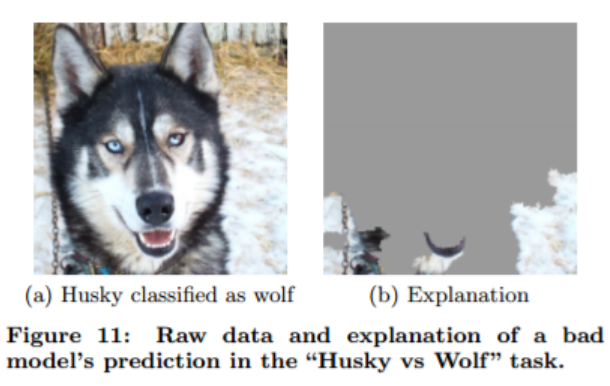

In [1]:
%matplotlib inline
from IPython.display import Image
Image("data/dg_vs_wolf.png")

Approach: Even for complex models like GBMs and DNN, we can use simple models to approximate them locally.

## Problem 1: Explain an individual prediction

Suppose we have a complex model $f$ and want to explain an instance $x \in \mathbb{R}^d$. First, we define an interpretable representation of $x$ as a binary vector $x' \in \{0,1\}^{d'}$.
Examples:
- For text classification $x$ might be the corresponding values of a tf-idf transformation, sequence of word embeddings, etc. $x'$ could be a set of indicators of whether given tokens appeared in the document.
- For image classification, elements of $x'$ could represent the presence or absence of a super pixel.

Given a collection $G$ of "interpretable" models (i.e. linear models) defined on $\{0,1\}^{d'}$, we want to find the one that best approximates $f$ in a neighborhood of $x$. We will use a proximity measure $\pi_x$, a loss function $\mathcal{L}$ and a complexity measure $\Omega$ and solve for $$\xi \left( x \right) = \mathrm{argmin}_{g \in G} \mathcal{L} \left( f,g,\pi_x \right) + \Omega \left(g \right)$$

For simplicity, take $\mathcal{L}$ to be locally weighted square loss, $$\pi_x\left(z\right) = \mathrm{exp}\left(-D\left(x,z\right)^2/\sigma^2\right)$$ where $D$ is a distance function with width $\sigma$.
That is, $$\mathcal{L} \left( f,g,\pi_x \right) = \sum_{z,z' \in \mathcal{Z}} \pi_x \left(z \right) \left( f(z) - g(z') \right)^2$$
We use the K-LASSO complexity function:
$$\Omega (g) = \infty \mathbb{1} \left[ \|w_g\|_0 > K \right]$$

Intuition behind LIME


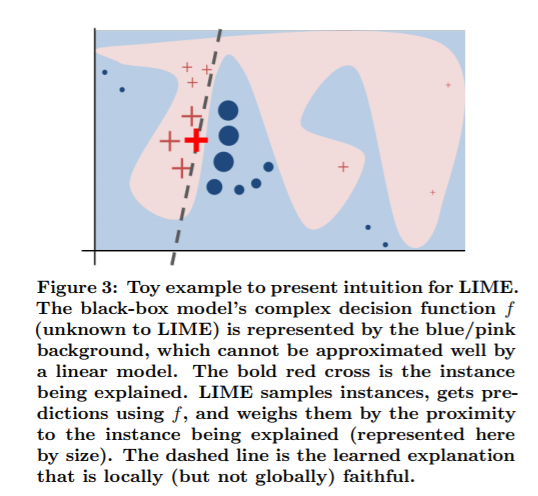

In [2]:
print("Intuition behind LIME")
Image("data/lime_intuition.png")

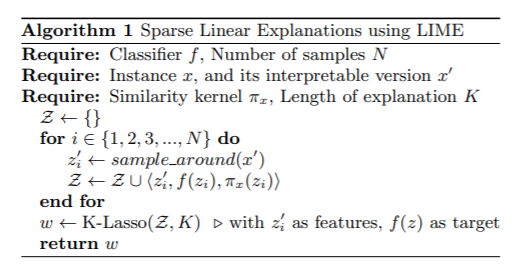

In [3]:
Image("data/lime_algo1.png")

## 20 Newsgroups Example

We'll use the 'rec.autos' and 'sci.space' categories from the 20 Newsgroups dataset to build a binary classifier and explain it with LIME.

In [4]:
import lime
from lime.lime_text import LimeTextExplainer
import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.pipeline import make_pipeline
from sklearn.datasets import fetch_20newsgroups
from operator import itemgetter

categories = ['rec.autos', 'sci.space']
newsgroups_train = fetch_20newsgroups(
    subset='train',
    categories=categories
    )

newsgroups_test = fetch_20newsgroups(
    subset='test',
    categories=categories
    )

class_names = ['rec.autos', 'sci.space']

We'll build a model in two steps:

- Fit a tf-idf vectorizer
- Fit a random forest on the tf-idf matrix

In [5]:
# Simple function for fitting a pipeline
def fit_pipeline(n_estimators = 500):
    vectorizer = TfidfVectorizer(lowercase = True)
    rf = RandomForestClassifier(
        n_estimators = n_estimators,
        random_state = 42)
    c = make_pipeline(vectorizer, rf)
    c.fit(newsgroups_train.data,newsgroups_train.target)
    return(c)

In [6]:
# Fit pipeline
c = fit_pipeline()

In [7]:
pred = c.predict(newsgroups_test.data)
f1s = f1_score(
    newsgroups_test.target,
    pred,
    average = 'binary')
print(f"F1 Score: {f1s: .3f}")

F1 Score:  0.963


In [8]:
probs_rec_auto = c.predict_proba(newsgroups_test.data[0:10])[:,0]
obs_to_exp = (
    min(enumerate(probs_rec_auto),key=itemgetter(1))[0],
    max(enumerate(probs_rec_auto),key=itemgetter(1))[0])

obs_to_exp = sorted(obs_to_exp)

for idx in obs_to_exp:
    print('Document id: %d' % idx)
    print('Probability(sci.space) =', c.predict_proba([newsgroups_test.data[idx]])[0, 1])
    print('True class: %s \n' % class_names[newsgroups_test.target[idx]])

Document id: 1
Probability(sci.space) = 0.102
True class: rec.autos 

Document id: 9
Probability(sci.space) = 0.854
True class: sci.space 



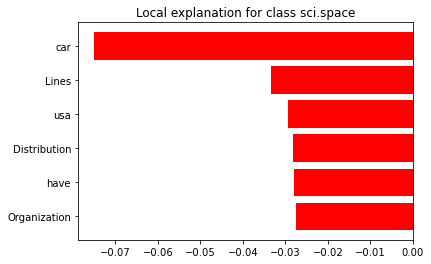

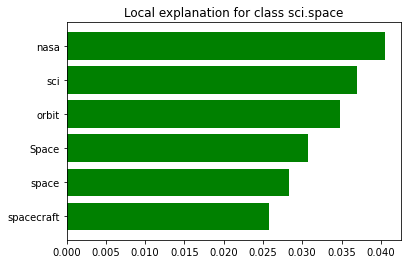

In [9]:
# Instantiate explainer
explainer = LimeTextExplainer(class_names=class_names)

# List to hold explanations of individual instances
exp_list = []

# Explain observations of interest
for idx in obs_to_exp:
    exp = explainer.explain_instance(newsgroups_test.data[idx], c.predict_proba, num_features=6)
    exp_list.append(exp)
    exp.as_pyplot_figure()

In [10]:
for exp in exp_list:
    exp.show_in_notebook(text=True)

In [11]:
newsgroups_train = fetch_20newsgroups(
    subset='train',
    categories=categories,
    remove = ('headers','footers','quotes')
    )

newsgroups_test = fetch_20newsgroups(
    subset='test',
    categories=categories,
    remove = ('headers','footers','quotes')
    )

In [12]:
# Fit pipeline
c = fit_pipeline()

# Recalculate F1 Score
pred = c.predict(newsgroups_test.data)
f1s = f1_score(
    newsgroups_test.target,
    pred,
    average = 'binary')
print(f"F1 Score: {f1s: .3f}")

F1 Score:  0.857


In [13]:
for idx in obs_to_exp:
    print('Document id: %d' % idx)
    print('Probability(sci.space) =', c.predict_proba([newsgroups_test.data[idx]])[0, 1])
    print('True class: %s \n' % class_names[newsgroups_test.target[idx]])

Document id: 1
Probability(sci.space) = 0.202
True class: rec.autos 

Document id: 9
Probability(sci.space) = 0.704
True class: sci.space 



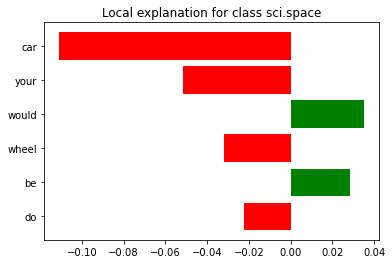

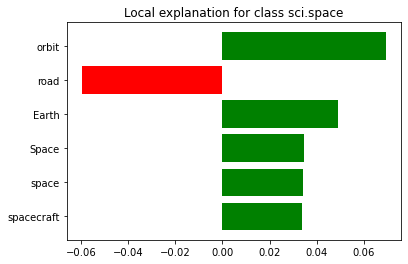

In [14]:
# Instantiate explainer
explainer = LimeTextExplainer(class_names=class_names)

exp_list = []

# Explain observations of interest
for idx in obs_to_exp:
    exp = explainer.explain_instance(newsgroups_test.data[idx], c.predict_proba, num_features=6)
    exp_list.append(exp)
    exp.as_pyplot_figure()

In [15]:
for exp in exp_list:
    exp.show_in_notebook(text=True)

### Problem 2: Explain the Model: Submodular Pick LIME (SP-LIME)

Now that we know how to explain individual observations locally, we want to explain the model globally by selecting an informative set of instances to explain using LIME.

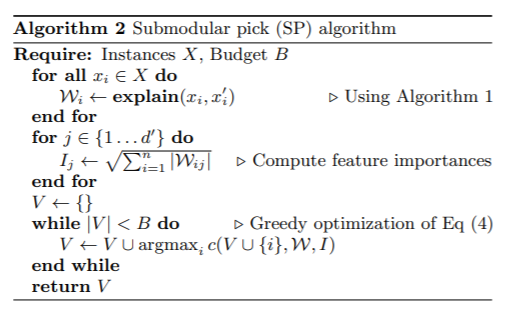

In [16]:
Image("data/lime_algo2.png")